In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
import pickle


In [ ]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load the datasets
train_df = pd.read_csv("KDDTrain+.txt", header=None)
test_df = pd.read_csv("KDDTest+.txt", header=None)

# Define column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'score'
]
train_df.columns = test_df.columns = columns

# Encode categorical features
categorical_columns = ['protocol_type', 'service', 'flag']
encoders = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])
    encoders[col] = encoder

# Convert labels to binary (1 = anomaly, 0 = normal)
y_train = train_df['label'].apply(lambda x: 1 if x != 'normal' else 0)
y_test = test_df['label'].apply(lambda x: 1 if x != 'normal' else 0)

# Drop non-feature columns
X_train = train_df.drop(columns=['label', 'score'])
X_test = test_df.drop(columns=['label', 'score'])

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import xgboost as xgb
import pickle

# Train the model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    n_estimators=100, learning_rate=0.1, max_depth=6
)
xgb_model.fit(X_train, y_train)

# Save the model
with open("xgb_nsl_kdd_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)
print("Model saved successfully!")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved successfully!


In [ ]:
# Load the saved model
with open("xgb_nsl_kdd_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Make predictions
y_pred = loaded_model.predict(X_test)


Accuracy: 80.97%
Precision: 96.8829
Recall: 68.7836
F1 Score: 80.4502
Confusion Matrix:
 [[9427  284]
 [4006 8827]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.69      0.80     12833

    accuracy                           0.81     22544
   macro avg       0.84      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



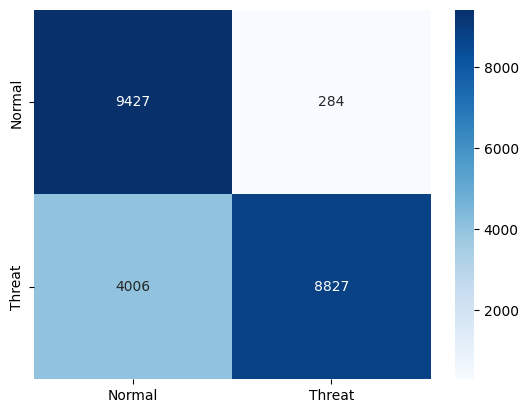

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score,precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Threat"], yticklabels=["Normal", "Threat"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred)* 100:.4f}")
print(f"Recall: {recall_score(y_test, y_pred)* 100:.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred)* 100:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


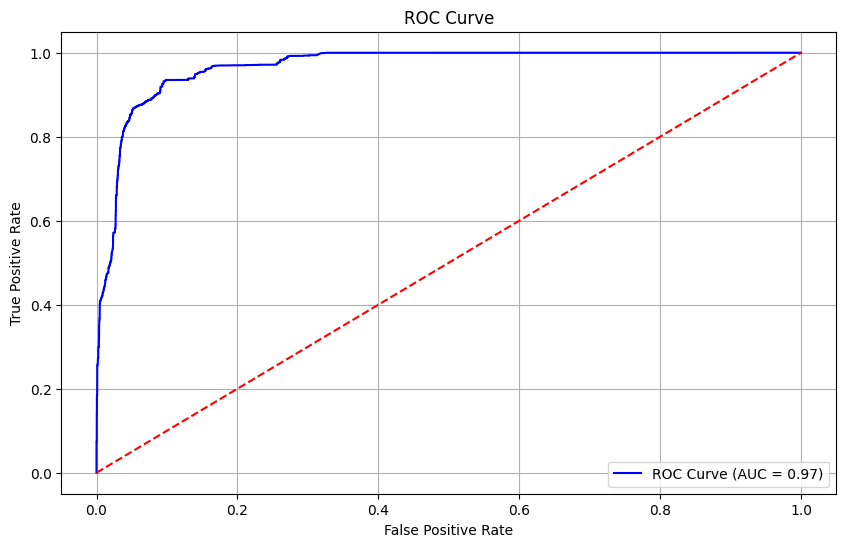

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC Curve
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


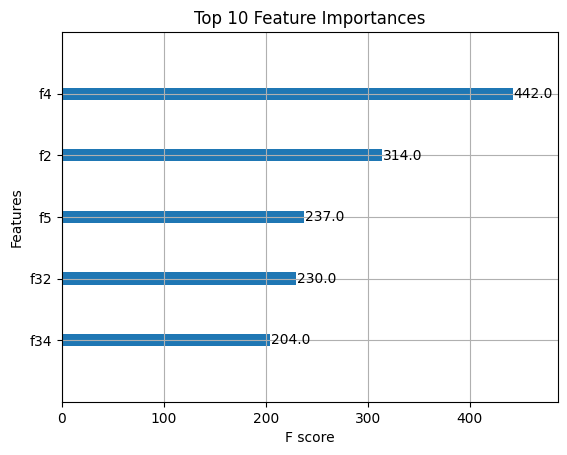

In [ ]:
# Plot feature importance
xgb.plot_importance(loaded_model, importance_type='weight', max_num_features=5, title="Top 10 Feature Importances")
plt.show()
